In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
from scipy.io import loadmat
import pandas as pd

## Loading the Data

We first initialize the paths to the dataset

In [2]:
url = "http://imagenet.stanford.edu/internal/car196/cars_train"
url_label = "https://ai.stanford.edu/~jkrause/cars/car_devkit"

path = Path('data/cars_train/');
path_label = Path('data/car_devkit/');

To train the plain ResNet50 and VGG19 networks we use the default data augmentations which are  
 - random horizontal flip with the probability of 0.5
 - random rotation of $\phi \in [-10°, +10°]$
 - random zoom of with maximal increase of 10% with the probability of 0.75
 - change of brightness by 20% with the probability of 0.75
 - change of contrast by 20% with the probability of 0.75

In [3]:
tfms = get_transforms()

Now we load the annotation files create a Data Frame for the training data showing the image name and the acording label (car model)

In [4]:
mat_data = loadmat('data/car_devkit/cars_train_annos.mat')
mat_meta = loadmat('data/car_devkit/cars_meta.mat')

class_id_label = mat_data['annotations']["class"].squeeze()
fname = mat_data['annotations']["fname"].squeeze()
class_names = mat_meta['class_names'].squeeze()

class_id_label_list = [class_id[0][0] for class_id in class_id_label]
fname_list = [f[0] for f in fname]
class_names_list = [c[0] for c in class_names]

class_name_label_list = [class_names_list[idx-1] for idx in class_id_label_list] 

train_df = pd.DataFrame(
    {'fname': fname_list,
     'label': class_name_label_list,
    })

train_df.head()

,fname,label
0,00001.jpg,Audi TTS Coupe 2012
1,00002.jpg,Acura TL Sedan 2012
2,00003.jpg,Dodge Dakota Club Cab 2007
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012


Finally we create the dataset from our training data with a 20% validation split.

In [5]:
data = (
    ImageList
    .from_df(df=train_df, path=path)
    .split_by_rand_pct(valid_pct=0.2, seed=1010) # Seed to make sure validation set is the same everytime we repeat an experiment
    .label_from_df(cols="label")
    .transform(tfms=tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
    .databunch(bs=16)
    .normalize(imagenet_stats) # Normalize Image according to ImageNet's Normalization because we are using ImageNet's pretrained model
)

The same has to be done for the test dataset too

In [6]:
test_path = untar_data('http://imagenet.stanford.edu/internal/car196/cars_test')
test_mat_path = download_data(url='http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels', ext=".mat")

mat_test = loadmat(path_label/'cars_test_annos.mat')
mat_test_label = loadmat(test_mat_path)

test_id_label = mat_test_label['annotations']["class"].squeeze()
test_fname = mat_test_label['annotations']["fname"].squeeze()

test_id_label_list = [class_id[0][0] for class_id in test_id_label]
test_fname_list = [f[0] for f in test_fname] 
class_names_list;

test_class_name_label_list = [class_names_list[idx-1] for idx in test_id_label_list] 

test_df = pd.DataFrame(
    {'fname': test_fname_list,
     'label': test_class_name_label_list,
    })

test_df.head()

,fname,label
0,00001.jpg,Suzuki Aerio Sedan 2007
1,00002.jpg,Ferrari 458 Italia Convertible 2012
2,00003.jpg,Jeep Patriot SUV 2012
3,00004.jpg,Toyota Camry Sedan 2012
4,00005.jpg,Tesla Model S Sedan 2012


In [7]:
df1 = train_df
df1["is_valid"] = False    # to dindicate what is the test data
df2 = test_df
df2["is_valid"] = True     # to dindicate what is the test data 
real_test_df = pd.concat([df1,df2])

In [8]:
real_test_df.head()

,fname,label,is_valid
0,00001.jpg,Audi TTS Coupe 2012,False
1,00002.jpg,Acura TL Sedan 2012,False
2,00003.jpg,Dodge Dakota Club Cab 2007,False
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,False
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,False


In [11]:
test_data = (
    ImageList
    .from_df(df=real_test_df, path=test_path)
    .split_from_df()
    .label_from_df(cols="label")
    .transform(tfms=tfms, size=224, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
    .databunch(bs=16)
    .normalize(imagenet_stats)
)

In [12]:
learnVgg = cnn_learner(data, models.vgg19_bn, metrics=[accuracy]).mixup()
learnResnet50 = cnn_learner(data, models.resnet50, metrics=[accuracy]).mixup()

By default the model will first train the fully connected layer and freeze all the layers before. This way we will be able to give the network an understanding about the new dataset. This is advisable to do, since many of the features (e.g. edges, simple shapes) are existent in the most datasets and do not need to be changed as much as the fully connected new layer with random weights.

## Training the models

With the learning rate finder we can visualize the expected steepest slope in the loss for different learning rates

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


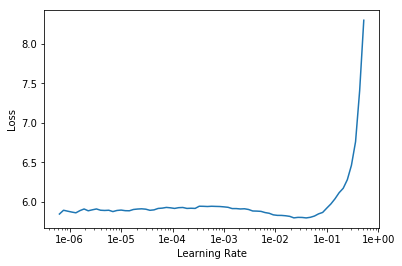

In [7]:
learnResnet50.lr_find()
learnResnet50.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


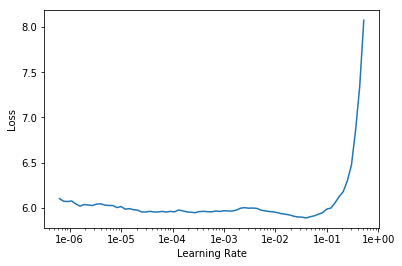

In [8]:
learnVgg.lr_find()
learnVgg.recorder.plot()

We pick a learning rate, wich is not too close to the divergence of the loss, but which is also not too small, to not slow down training. We than use the cyclic learning rate scheduler to train both pretrained models (ResNet50, VGG19) for 15 epochs each

In [9]:
learnResnet50.fit_one_cycle(15, max_lr=slice(1e-3))
learnVgg.fit_one_cycle(15, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,5.571149,5.012107,0.034398,00:49
1,4.973609,4.171848,0.133292,00:41
2,4.372349,3.536293,0.238943,00:42
3,4.026829,3.031713,0.324939,00:42
4,3.645621,2.597118,0.385749,00:42
5,3.353887,2.273504,0.460688,00:42
6,3.182794,2.063423,0.497543,00:42
7,2.997269,1.900434,0.535627,00:42
8,2.837066,1.777403,0.566339,00:42
9,2.704211,1.682934,0.592138,00:42


epoch,train_loss,valid_loss,accuracy,time
0,5.809074,5.348483,0.009828,00:59
1,5.341213,4.729391,0.060811,00:59
2,4.716233,3.956143,0.171376,00:59
3,4.229847,3.323509,0.270270,00:59
4,3.937204,2.905787,0.321867,00:59
5,3.520218,2.557034,0.413391,00:59
6,3.424897,2.328583,0.463759,01:00
7,3.314513,2.129712,0.502457,00:59
8,3.064509,2.022123,0.517199,00:59
9,3.069438,1.927854,0.544226,01:00


Both models seem to converge after nearly 15 epochs. Now we can unfreeze all layers and train everything together and enable the models to recognise more dataset-specific structures.

In [10]:
learnResnet50.unfreeze()
learnVgg.unfreeze()

We will train the models for 15 epochs with an intervall of learning rates between $[10^{-3}, 10^{-5}]$

In [11]:
learnResnet50.fit_one_cycle(15, max_lr=slice(1e-5, 1e-3))
learnVgg.fit_one_cycle(15, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.382427,1.467029,0.633292,00:53
1,2.374608,1.365705,0.658477,00:53
2,2.446267,1.404040,0.646192,00:53
3,2.497180,1.313040,0.668919,00:54
4,2.318475,1.181429,0.697789,00:54
5,2.229234,1.044219,0.728501,00:53
6,2.094200,0.888102,0.770270,00:54
7,1.936553,0.849913,0.771499,00:53
8,1.795909,0.767169,0.806511,00:53
9,1.672865,0.699395,0.812654,00:53


epoch,train_loss,valid_loss,accuracy,time
0,2.655307,1.644128,0.601351,01:20
1,2.528968,1.456433,0.651106,01:20
2,2.510470,1.313605,0.672604,01:20
3,2.501689,1.181223,0.702703,01:20
4,2.341998,1.029794,0.745700,01:20
5,2.247870,0.921610,0.762285,01:20
6,2.078096,0.830938,0.786241,01:20
7,1.910732,0.776918,0.810811,01:20
8,1.797324,0.670497,0.847052,01:20
9,1.692439,0.629431,0.850123,01:20


The models seem to converge again. To make sure we look at the learning rate visualization

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


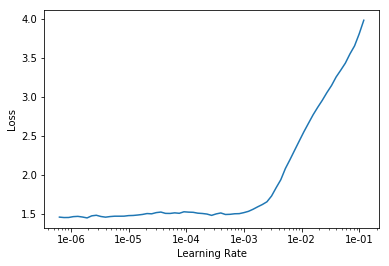

In [12]:
learnResnet50.lr_find()
learnResnet50.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


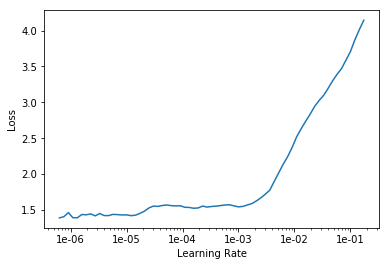

In [13]:
learnVgg.lr_find()
learnVgg.recorder.plot()

It seems like there are no clear learning rate values to improve the models significantly. But we try to train the model with smaller learning rates from $[10^{-4}, 10^{-7}]$ to see if the model can still do slightly better

In [14]:
learnResnet50.fit_one_cycle(15, max_lr=slice(1e-7, 1e-4))
learnVgg.fit_one_cycle(15, max_lr=slice(1e-7, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.490370,0.595890,0.847052,00:53
1,1.414499,0.600399,0.847052,00:53
2,1.469679,0.596429,0.846437,00:53
3,1.458329,0.591926,0.852580,00:53
4,1.446447,0.598297,0.851351,00:53
5,1.493941,0.596355,0.845209,00:52
6,1.480332,0.595493,0.854423,00:53
7,1.485270,0.589603,0.847666,00:53
8,1.464796,0.587301,0.851966,00:52
9,1.418324,0.599769,0.853194,00:53


epoch,train_loss,valid_loss,accuracy,time
0,1.483232,0.538989,0.877150,01:19
1,1.465323,0.535800,0.879607,01:19
2,1.475716,0.536098,0.878993,01:19
3,1.474801,0.538104,0.879607,01:19
4,1.550194,0.531450,0.879607,01:19
5,1.494874,0.534145,0.875921,01:20
6,1.493323,0.533266,0.878993,01:20
7,1.439667,0.539666,0.878993,01:21
8,1.466668,0.537104,0.886364,01:20
9,1.460295,0.533085,0.885135,01:20


In [15]:
# learnResnet50.save('trained resnet50')
# learnVgg.save('trained vgg19', return_path=True)

PosixPath('data/cars_train/models/trained vgg19.pth')

The models do not seem to improve any further. We now test the accuracies on the test set

In [16]:
learnResnet50.validate(test_data.valid_dl)

[0.5607203, tensor(0.8705)]

In [17]:
learnVgg.validate(test_data.valid_dl)

[0.50539136, tensor(0.8886)]

So we archieve an accuracy of $87\%$ with the ResNet50 and $88,8\%$ with the VGG19 network